In [9]:
import os
import sys
import re
import pandas as pd 
import cantera as ct 
from subprocess import run
import graphviz
from IPython.display import display
from pathlib import Path

# --- 1) Define your case name up front ---
case_name = "NH3_NP_sim"

# --- 2) Push your src/ directory onto sys.path ---
project_root = os.getcwd()              # adjust if needed
src_dir      = os.path.join(project_root, 'src')
print("src_dir:", src_dir)
sys.path.insert(0, src_dir)

# --- 3) Now import the generator from props_1D ---
from props_1D import generate_props

# --- 4) Generate props_list and add mechanism path so Cantera can find it ---
props_list = generate_props(case_name)
mech_path  = props_list[0]['mech_path']
sys.path.append(os.path.abspath(mech_path))

# --- 6) Initialize Cantera gas object ---
props     = props_list[0]
last_spec = 'AR'
gas0      = ct.Solution(props['mech_file'])
specs     = gas0.species()[:]
N2_ind    = gas0.species_index(last_spec)
gas       = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=specs[:N2_ind] + specs[N2_ind+1:] + [specs[N2_ind]],
    reactions=gas0.reactions()
)
main_species_names = gas.species_names

src_dir: /data/ZhuXu/Cantera/NeuralRecon/src


Running under: base
Cantera version: 2.6.0

--- plotting element 'O' (min_pct=20.0%) ---
→ Wrote simplified & recolored DOT to figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix/N_CF_NH3_0.40_H2_0.40_N2_0.20/Otomo_32s213r/O_rxnpath_simple.dot
→ Wrote final PDF to figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix/N_CF_NH3_0.40_H2_0.40_N2_0.20/Otomo_32s213r/O_rxnpath.pdf


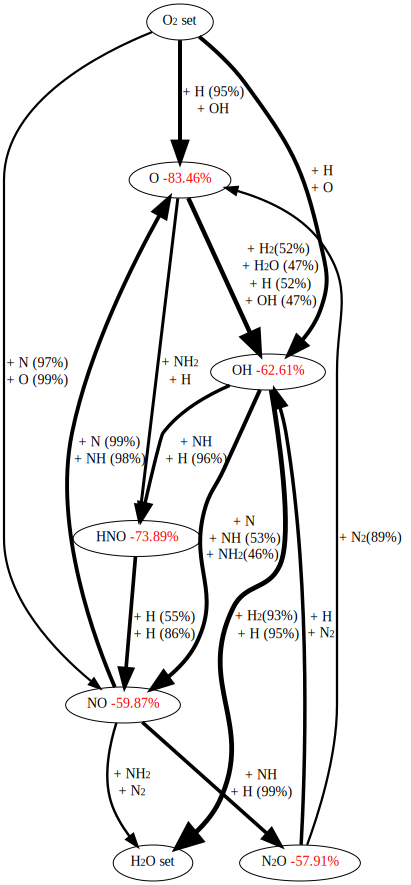

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import subprocess
import re
import cantera as ct
import graphviz
import pandas as pd
from typing import List

print("Running under:", os.environ.get("CONDA_DEFAULT_ENV", "<unknown>"))
print("Cantera version:", ct.__version__)


def _html_subscript_numbers(s: str) -> str:
    # wrap digits in a slightly larger subscript so baseline sits higher
    return re.sub(
        r'(\d+)',
        r'<SUB><FONT POINT-SIZE="10">\1</FONT></SUB>',
        s
    )


def simplify_dot_file(
    in_dot: str,
    out_dot: str,
    min_pct: float = 0.0,
    shrink_factor: float = 0.5,
    edge_color: str = "gray"
):
    text = open(in_dot, 'r').read()

    # remove overall graph-level label=
    text = re.sub(r'^\s*label\s*=\s*"[^"]*";\s*\n', '', text, flags=re.MULTILINE)

    # ── 1) global font & layout ───────────────────────────────────────────────
    text = re.sub(
        r'(digraph[^{]*\{)',
        r'\1\n'
        r'  graph [fontname="Times-Roman", nodesep=0, ranksep=1.2, margin=0];\n'
        r'  node  [fontname="Times-Roman"];\n'
        r'  edge  [fontname="Times-Roman"];\n',
        text, count=1
    )

    # ── 2) simplify + style edges ─────────────────────────────────────────────
    edge_rx = re.compile(r'(\s*\w+\s*->\s*\w+)\[\s*(.*?)\s*\](;?)', re.DOTALL)
    def repl_edge(m):
        head, body, tail = m.group(1), m.group(2), m.group(3)
        parts = re.split(r',\s*(?=[a-zA-Z]+=)', body)
        keep = ['fontname="Times-Roman"']
        for p in parts:
            p = p.strip()
            if p.startswith('penwidth'):
                k, v = p.split('=', 1)
                keep.append(f"{k}={float(v) * shrink_factor:.2f}")
            elif p.startswith('arrowsize'):
                k, v = p.split('=', 1)
                keep.append(f"{k}={float(v) * shrink_factor:.2f}")

        keep.append(f'color="{edge_color}"')

        # parse label, filter by min_pct, and apply subscripts
        lab_m = re.search(r'label="([^"]*)"', body, re.DOTALL)
        raw = lab_m.group(1) if lab_m else ""
        co_lines = []
        for raw_line in raw.split(r'\l'):
            line = raw_line.strip()
            if not line.startswith('+'):
                continue
            pct_m = re.search(r'\((\d+\.?\d*)%\)', line)
            if pct_m:
                pct_val = float(pct_m.group(1))
                if pct_val < min_pct:
                    continue
                sp = line[2:line.index(' (')]
                sp_html = _html_subscript_numbers(sp)
                new_line = f"+ {sp_html} ({int(pct_val)}%)"
            else:
                sp = line[2:]
                sp_html = _html_subscript_numbers(sp)
                new_line = f"+ {sp_html}"
            co_lines.append(new_line)

        if co_lines:
            # build a little table so we can control row spacing
            rows = "".join(
                f'<TR><TD><FONT FACE="Times-Roman" COLOR="{edge_color}">{ln}</FONT></TD></TR>'
                for ln in co_lines
            )
            keep.append(
                f'label=<<TABLE BORDER="0" CELLSPACING="2" CELLPADDING="0" ALIGN="LEFT">{rows}</TABLE>>'
            )
        return f"{head}[{', '.join(keep)}]{tail}"

    text = edge_rx.sub(repl_edge, text)

    # ── 3) reformat nodes ─────────────────────────────────────────────────────
    node_rx = re.compile(
        r'^\s*(\w+)\s*\[\s*fontname="[^"]*"\s*,\s*'
        r'label="([^"]*?)"\s*,\s*style=filled\s*,\s*'
        r'fillcolor="(?P<col>#[0-9A-Fa-f]{6})"\s*\];',
        re.MULTILINE
    )
    def repl_node(m):
        name, lab = m.group(1), m.group(2).strip()
        if ' ' in lab:
            sp, err = lab.rsplit(' ', 1)
        else:
            sp, err = lab, ''
        sp_html = _html_subscript_numbers(sp)
        html = f'label=<<FONT FACE="Times-Roman" COLOR="black">{sp_html}</FONT>'
        if err:
            try:
                pct = abs(float(err.strip('%')))
            except ValueError:
                pct = 0.0
            clr = 'red' if pct >= 50.0 else 'black'
            html += f' <FONT FACE="Times-Roman" COLOR="{clr}">{err}</FONT>>'
        else:
            html += '>>'
        return f'  {name} [{html}];'

    text = node_rx.sub(repl_node, text)

    with open(out_dot, 'w') as f:
        f.write(text)
    print("→ Wrote simplified & recolored DOT to", out_dot)


def postprocess(
    fig_dir: str,
    element: str,
    cantera_row: pd.Series,
    pred_cantera_row: pd.Series,
    min_pct: float = 20.0,
    shrink_factor: float = 0.5,
    edge_color: str = "gray"
):
    raw_dot    = os.path.join(fig_dir, f"{element}_rxnpath_modified.dot")
    simple_dot = os.path.join(fig_dir, f"{element}_rxnpath_simple.dot")
    pdf_path   = os.path.join(fig_dir, f"{element}_rxnpath.pdf")

    simplify_dot_file(
        raw_dot, simple_dot,
        min_pct=min_pct,
        shrink_factor=shrink_factor,
        edge_color=edge_color
    )

    try:
        subprocess.run(
            ["dot", "-Tpdf", simple_dot, "-o", pdf_path, "-Gdpi=300"],
            check=True, capture_output=True, text=True
        )
        print(f"→ Wrote final PDF to {pdf_path}")
    except subprocess.CalledProcessError as e:
        print("⛔ Graphviz failed:\n", e.stderr)

    # inline display in notebook
    try:
        src = graphviz.Source.from_file(simple_dot, format='dot')
        display(src)
    except Exception:
        pass


def make_diagrams(
    fig_dir: str,
    orig_csv: str,
    elements: List[str] = None,
    min_pct: float = 20.0,
    shrink_factor: float = 0.5,
    edge_color: str = "gray"
):
    df       = pd.read_csv(orig_csv)
    pred_fn  = os.path.join(fig_dir, "predicted_X.csv")
    df_pred  = pd.read_csv(pred_fn)

    idx      = df['HRR'].idxmax()
    row_can  = df.loc[idx]
    row_pred = df_pred.loc[idx]

    if elements is None:
        elements = ['O', 'H', 'N']

    for elt in elements:
        print(f"\n--- plotting element '{elt}' (min_pct={min_pct}%) ---")
        postprocess(
            fig_dir, elt, row_can, row_pred,
            min_pct=min_pct,
            shrink_factor=shrink_factor,
            edge_color=edge_color
        )



# Example calls: adjust shrink_factor (e.g. 0.3 for thinner) and edge_color as desired
make_diagrams(
    # fig_dir="figs/QSSA/SIM_results/NH3_NP_CF_reduce_ori_maxHRR/N_30/",
    fig_dir="figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix/N_CF_NH3_0.40_H2_0.40_N2_0.20/Otomo_32s213r",
    orig_csv="SIM_results/case_NH3_counterflow_PCI_matrix/Otomo_32s213r/N_CF_NH3_0.40_H2_0.40_N2_0.20.csv",
    elements=['O'],
    min_pct=20.0,
    shrink_factor=0.8,
    edge_color='black'
)

# make_diagrams(
#     fig_dir="figs/QSSA/SIM_results/NH3_NP_CF_reduce_OH_maxHRR/N_30/",
#     orig_csv="SIM_results/NH3_NP_CF_reduce/N_30.csv",
#     elements=['O'],
#     min_pct=20.0,
#     shrink_factor=0.8,
#     edge_color='black'
# )

# make_diagrams(
#     fig_dir="figs/QSSA/SIM_results/NH3_NP_CF_reduce_NH_maxHRR/N_30/",
#     orig_csv="SIM_results/NH3_NP_CF_reduce/N_30.csv",
#     elements=['O'],
#     min_pct=20.0,
#     shrink_factor=0.8,
#     edge_color='black'
# )



--- plotting element 'O' (min_pct=20.0%) ---
→ Wrote simplified & recolored DOT to figs/QSSA/SIM_results/NH3_NP_CF_reduce_ori_maxOH/N_30/O_rxnpath_simple.dot
→ Wrote final PDF to figs/QSSA/SIM_results/NH3_NP_CF_reduce_ori_maxOH/N_30/O_rxnpath.pdf


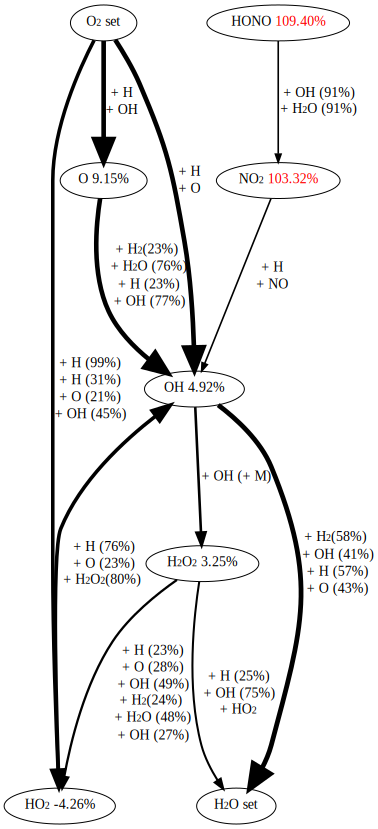

In [17]:
# Example calls: adjust shrink_factor (e.g. 0.3 for thinner) and edge_color as desired
make_diagrams(
    fig_dir="figs/QSSA/SIM_results/NH3_NP_CF_reduce_ori_maxOH/N_30/",
    orig_csv="SIM_results/NH3_NP_CF_reduce/N_30.csv",
    elements=['O'],
    min_pct=20.0,
    shrink_factor=0.8,
    edge_color='black'
)


--- plotting element 'N' (min_pct=20.0%) ---
→ Wrote simplified & recolored DOT to figs/QSSA/SIM_results/NH3_NP_CF_reduce_ori_maxNO/N_30/N_rxnpath_simple.dot
→ Wrote final PDF to figs/QSSA/SIM_results/NH3_NP_CF_reduce_ori_maxNO/N_30/N_rxnpath.pdf


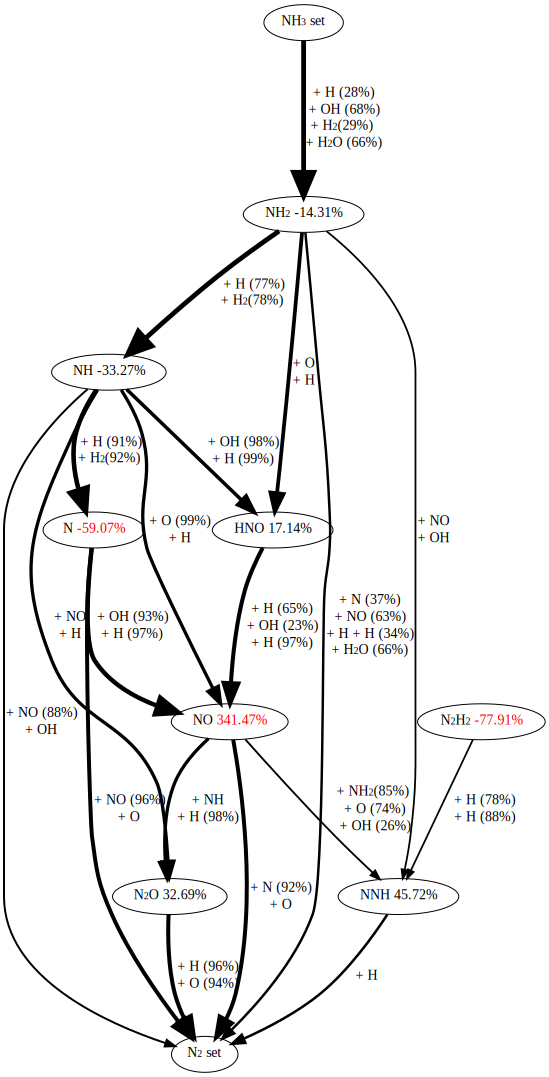


--- plotting element 'N' (min_pct=20.0%) ---
→ Wrote simplified & recolored DOT to figs/QSSA/SIM_results/NH3_NP_CF_reduce_OH_maxNO/N_30/N_rxnpath_simple.dot
→ Wrote final PDF to figs/QSSA/SIM_results/NH3_NP_CF_reduce_OH_maxNO/N_30/N_rxnpath.pdf


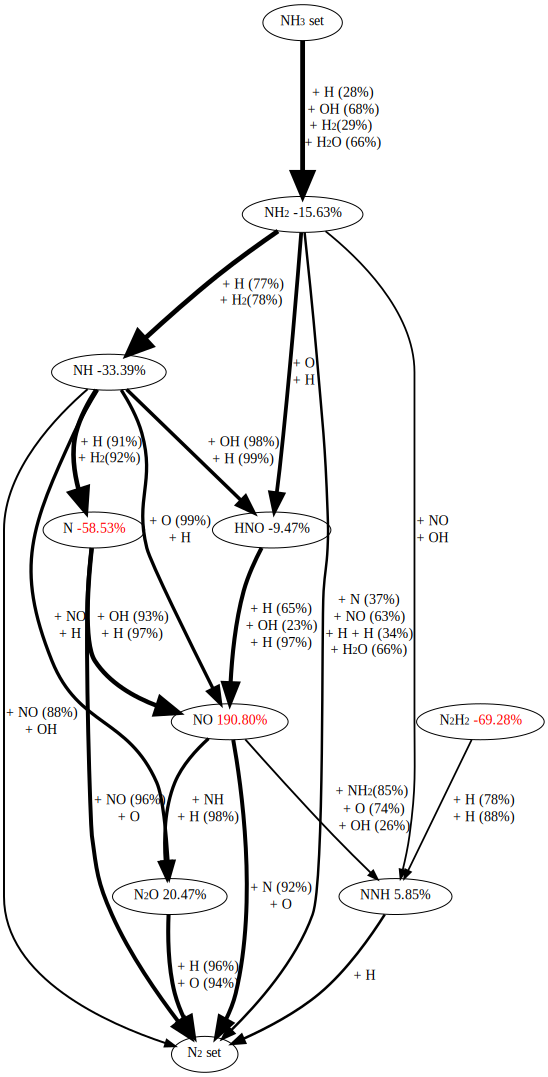


--- plotting element 'N' (min_pct=20.0%) ---
→ Wrote simplified & recolored DOT to figs/QSSA/SIM_results/NH3_NP_CF_reduce_NH_maxNO/N_30/N_rxnpath_simple.dot
→ Wrote final PDF to figs/QSSA/SIM_results/NH3_NP_CF_reduce_NH_maxNO/N_30/N_rxnpath.pdf


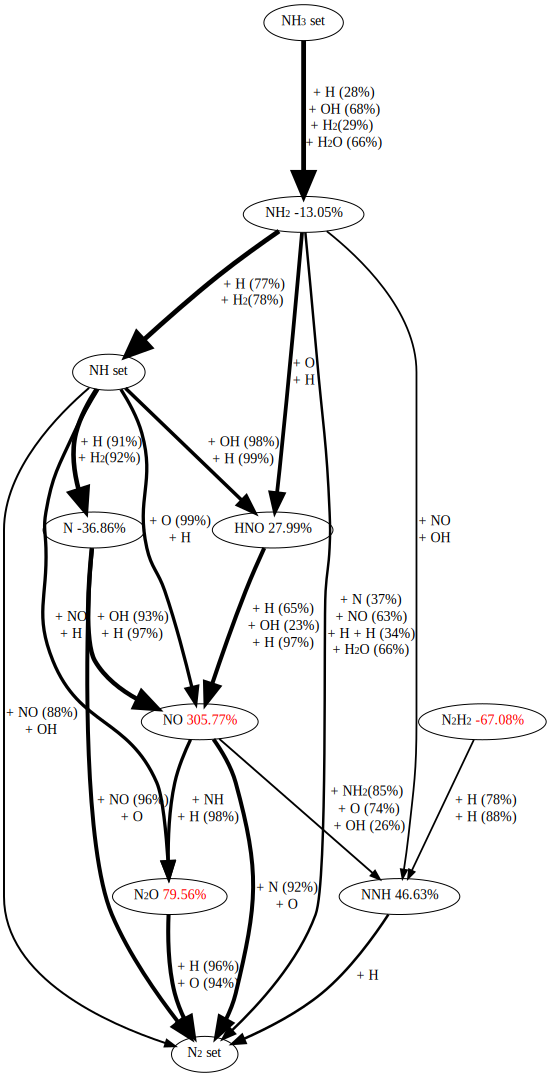

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import subprocess
import re
import cantera as ct
import graphviz
import pandas as pd
import networkx as nx
from typing import List

print("Running under:", os.environ.get("CONDA_DEFAULT_ENV", "<unknown>"))
print("Cantera version:", ct.__version__)


def _html_subscript_numbers(s: str) -> str:
    return re.sub(
        r'(\d+)',
        r'<SUB><FONT POINT-SIZE="10">\1</FONT></SUB>',
        s
    )


def simplify_dot_file(
    in_dot: str,
    out_dot: str,
    min_pct: float = 0.0,
    shrink_factor: float = 0.5,
    edge_color: str = "gray"
):
    text = open(in_dot, 'r').read()

    # strip any existing label=
    text = re.sub(r'^\s*label\s*=\s*"[^"]*";\s*\n',
                  '', text, flags=re.MULTILINE)

    # 1) inject global font/layout
    text = re.sub(
        r'(digraph[^{]*\{)',
        r'\1\n'
        r'  graph [fontname="Times-Roman", nodesep=0, ranksep=1.2, margin=0];\n'
        r'  node  [fontname="Times-Roman"];\n'
        r'  edge  [fontname="Times-Roman"];\n',
        text, count=1
    )

    # 2) simplify & style edges
    edge_rx = re.compile(r'(\s*\w+\s*->\s*\w+)\[\s*(.*?)\s*\](;?)',
                         re.DOTALL)
    def repl_edge(m):
        head, body, tail = m.group(1), m.group(2), m.group(3)
        parts = re.split(r',\s*(?=[a-zA-Z]+=)', body)
        keep = ['fontname="Times-Roman"']
        for p in parts:
            if p.startswith('penwidth'):
                k, v = p.split('=',1)
                keep.append(f"{k}={float(v)*shrink_factor:.2f}")
            elif p.startswith('arrowsize'):
                k, v = p.split('=',1)
                keep.append(f"{k}={float(v)*shrink_factor:.2f}")
        keep.append(f'color="{edge_color}"')

        # rebuild label as HTML table
        lab_m = re.search(r'label="([^"]*)"', body, re.DOTALL)
        raw = lab_m.group(1) if lab_m else ""
        rows = []
        for line in raw.split(r'\l'):
            line = line.strip()
            if not line.startswith('+'):
                continue
            pct = re.search(r'\((\d+\.?\d*)%\)', line)
            if pct and float(pct.group(1))<min_pct:
                continue
            text_part = line[2:line.find(' (')] if pct else line[2:]
            text_part = _html_subscript_numbers(text_part)
            suffix = f" ({int(pct.group(1))}%)" if pct else ""
            rows.append(f"<TR><TD><FONT FACE=\"Times-Roman\" COLOR=\"{edge_color}\">+ {text_part}{suffix}</FONT></TD></TR>")
        if rows:
            keep.append(
                'label=<<TABLE BORDER="0" CELLSPACING="2" CELLPADDING="0" ALIGN="LEFT">'
                + "".join(rows) +
                '</TABLE>>'
            )

        return f"{head}[{', '.join(keep)}]{tail}"

    text = edge_rx.sub(repl_edge, text)

    # 3) reformat nodes
    node_rx = re.compile(
        r'^\s*(\w+)\s*\[\s*fontname="[^"]*"\s*,\s*'
        r'label="([^"]*?)"\s*,\s*style=filled\s*,\s*'
        r'fillcolor="(?P<col>#[0-9A-Fa-f]{6})"\s*\];',
        re.MULTILINE
    )
    def repl_node(m):
        name, lab = m.group(1), m.group(2).strip()
        sp, err = (lab.rsplit(' ',1) if ' ' in lab else (lab,''))
        sp_html = _html_subscript_numbers(sp)
        html = f'label=<<FONT FACE="Times-Roman" COLOR="black">{sp_html}</FONT>'
        if err:
            pct = 0.0
            try: pct = abs(float(err.strip('%')))
            except: pass
            clr = 'red' if pct>=50 else 'black'
            html += f' <FONT FACE="Times-Roman" COLOR="{clr}">{err}</FONT>>'
        else:
            html += '>>'
        return f'  {name} [{html}];'

    text = node_rx.sub(repl_node, text)

    with open(out_dot, 'w') as fh:
        fh.write(text)
    print("→ wrote simplified DOT to", out_dot)


def postprocess(
    fig_dir: str,
    element: str,
    cantera_row: pd.Series,
    pred_cantera_row: pd.Series,
    min_pct: float = 20.0,
    shrink_factor: float = 0.5,
    edge_color: str = "gray"
):
    raw_dot    = os.path.join(fig_dir, f"{element}_rxnpath_modified.dot")
    simple_dot = os.path.join(fig_dir, f"{element}_rxnpath_simple.dot")
    svg_path   = os.path.join(fig_dir, f"{element}_rxnpath.svg")
    gml_path   = os.path.join(fig_dir, f"{element}_rxnpath.graphml")

    # simplify the DOT
    simplify_dot_file(
        raw_dot, simple_dot,
        min_pct=min_pct,
        shrink_factor=shrink_factor,
        edge_color=edge_color
    )

    # 1) export SVG
    try:
        subprocess.run(
            ["dot", "-Tsvg", simple_dot, "-o", svg_path, "-Gdpi=300"],
            check=True, capture_output=True, text=True
        )
        print(f"→ wrote SVG to {svg_path}")
    except subprocess.CalledProcessError as e:
        print("⛔ Graphviz SVG error:\n", e.stderr)

    # 2) export GraphML for draw.io
    try:
        G = nx.drawing.nx_pydot.read_dot(simple_dot)
        # optionally strip HTML labels or set them as attributes
        # nx.set_node_attributes(G, ..., 'label')
        nx.write_graphml(G, gml_path)
        print(f"→ wrote GraphML to {gml_path}")
    except Exception as e:
        print("⛔ GraphML export error:", e)

    # inline preview (if in notebook)
    try:
        src = graphviz.Source.from_file(simple_dot, format='svg')
        display(src)
    except:
        pass


def make_diagrams(
    fig_dir: str,
    orig_csv: str,
    elements: List[str] = None,
    min_pct: float = 20.0,
    shrink_factor: float = 0.5,
    edge_color: str = "gray"
):
    df      = pd.read_csv(orig_csv)
    df_pred = pd.read_csv(os.path.join(fig_dir, "predicted_X.csv"))
    idx     = df['HRR'].idxmax()

    if elements is None:
        elements = ['O','H','N']

    for elt in elements:
        print(f"\n--- plotting '{elt}' (min={min_pct}%) ---")
        postprocess(
            fig_dir, elt,
            df.loc[idx], df_pred.loc[idx],
            min_pct=min_pct,
            shrink_factor=shrink_factor,
            edge_color=edge_color
        )


if __name__=="__main__":
    make_diagrams(
        fig_dir="figs/QSSA/SIM_results/…/Otomo_32s213r",
        orig_csv="SIM_results/.../Otomo_32s213r.csv",
        elements=['O'],
        min_pct=20.0,
        shrink_factor=0.8,
        edge_color='black'
    )

In [4]:
# # Example calls: adjust shrink_factor (e.g. 0.3 for thinner) and edge_color as desired
# make_diagrams(
#     fig_dir="figs/QSSA/SIM_results/NH3_NP_CF_reduce_ori_maxNO/N_30/",
#     orig_csv="SIM_results/NH3_NP_CF_reduce/N_30.csv",
#     elements=['H'],
#     min_pct=20.0,
#     shrink_factor=0.8,
#     edge_color='black'
# )

# make_diagrams(
#     fig_dir="figs/QSSA/SIM_results/NH3_NP_CF_reduce_OH_maxNO/N_30/",
#     orig_csv="SIM_results/NH3_NP_CF_reduce/N_30.csv",
#     elements=['H'],
#     min_pct=20.0,
#     shrink_factor=0.8,
#     edge_color='black'
# )

# make_diagrams(
#     fig_dir="figs/QSSA/SIM_results/NH3_NP_CF_reduce_NH_maxNO/N_30/",
#     orig_csv="SIM_results/NH3_NP_CF_reduce/N_30.csv",
#     elements=['H'],
#     min_pct=20.0,
#     shrink_factor=0.8,
#     edge_color='black'
# )
